## Results of Host Prediction
### Dataset: EMBL mapping, Vertebrates, Non-IDV

**Models**: FNN, CNN, RNN, LSTM, TF

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1036

**Classification**: Multi-class

**\# classes**: 5

**\# train samples** = 

**\# validation samples** = 

**\# test samples** = 

In [1]:
import seaborn
! echo "Y" > pip uninstall statannotations
! echo "Y" > pip uninstall seaborn
!pip install seaborn==0.13.0

In [2]:
seaborn.__version__

'0.13.0'

In [3]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/embl',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/embl/../../../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/embl/../../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/embl/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/embl/../..']

In [4]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils

In [5]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['figure.autolayout'] = True

DEFAULT_FIGURE_CONFIG = {
    "figsize": (10, 10),
    "xtick.labelsize": 18,
    "ytick.labelsize": 18    
}


def plot_auprc(auprc_df, metadata, model_name):
    # sort by median
    sorted_median_auprc_df = auprc_df.groupby("class")["auprc"].median().sort_values(ascending=False)
    visualization_utils.pre_plot_config(DEFAULT_FIGURE_CONFIG)
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    ax = sns.boxplot(data=auprc_df, x="class", y="auprc", order=sorted_median_auprc_df.index)
    
    ax.set_ylim(0, 1)
    # ax.set_xticklabels([metadata[t.get_text()] for t in ax.get_xticklabels()])
    ax.set_title(f"Model = {model_name}")
    plt.tight_layout()
    plt.xticks(rotation=-90)
    plt.show()
        
def auprc_analysis(output_filepath, model_name):
    df = pd.read_csv(output_filepath, index_col=0)
    print(f"Read output size = {df.shape}")
    cols = df.columns
    non_human_cols = list(set(cols) - set([itr_col, experiment_col, y_true_col, human_col]))
    print(f"NonHuman cols = {non_human_cols}")
    itrs = df[itr_col].unique()
    
    auprc = []
    pr_curves = []
    for itr in itrs:
        df_itr = df[df[itr_col] == itr]
        pr_curves_df, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=non_human_cols + [human_col], y_true_col=y_true_col)
        pr_curves_df[itr_col] = itr
        auprcs_df[itr_col] = itr
        auprc.append(auprcs_df)
        pr_curves.append(pr_curves_df)

    auprc_df = pd.concat(auprc, ignore_index=True)
    pr_curves_df = pd.concat(pr_curves, ignore_index=True)
    
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    
    plot_auprc(auprc_df, metadata, model_name)
    visualization_utils.curve_plot(pr_curves_df, x_col="recall", y_col="precision",
                                   color_group_col="class", style_group_col=None,
                                   output_file_path=None, metadata=metadata)
    

def auprc_analysis_classes_subset(output_filepaths, classes):
    macro_auprcs = []
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            macro_auprcs.append({"model": model,
                                 "itr": itr,
                                 "auprc": auprcs_df["auprc"].mean()})
    macro_auprcs_df = pd.DataFrame(macro_auprcs)

    visualization_utils.pre_plot_config(DEFAULT_FIGURE_CONFIG)
    ax = sns.boxplot(data=macro_auprcs_df, x="model", y="auprc")
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=20)
    ax.set_title(f"Macro AUPRC [Classes = {classes}]")
    visualization_utils.wrap_xticklabels(ax)
    visualization_utils.view(figure_output_filepath)
    plt.show()
    

In [27]:
def class_wise_auprc_analysis(output_filepaths, classes, figure_output_filepath):
    auprc_results = []
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        cols = df.columns
        classes = list(set(cols) - set([itr_col, experiment_col, y_true_col]))
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            auprcs_df["model"] = model
            auprcs_df["itr"] = itr
            auprc_results.append(auprcs_df)
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v

    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class":metadata_formatted}, inplace=True)
    
    FIGURE_CONFIG = {
        "figsize": (15, 10),
        "xtick.labelsize": 20,
        "ytick.labelsize": 20    
    }

    visualization_utils.pre_plot_config(FIGURE_CONFIG)
    ax = sns.boxplot(data=auprc_results_df, x="class", y="auprc", hue="model", order=metadata_sorted, linewidth=1.5, fliersize=5)
    plt.draw()
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=22)
    ax.set_xlabel("", size=22, labelpad=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)
    plt.setp(ax.get_legend().get_texts(), fontsize=16)
    visualization_utils.wrap_xticklabels(ax)
    visualization_utils.view(figure_output_filepath)
    plt.show()
    return auprc_results_df

### LR

In [18]:
lr_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240515/host_multi/kmer_k3_virus_host_name_multi__lr_output.csv")
#auprc_analysis(lr_output_filepath, "LR")

### RF

In [19]:
rf_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240515/host_multi/kmer_k3_virus_host_name_multi__rf_output.csv")
#auprc_analysis(rf_output_filepath, "RF")

### SVM

In [20]:
svm_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240522/host_multi/kmer_k3_virus_host_name_multi__svm_output.csv")
#auprc_analysis(svm_output_filepath, "SVM")

### FNN

In [7]:
fnn_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240229/host_multi/emb_sincos-lossfocalce_e50_msl1036_fnn-l_10-d_1024-lr1e-3_output.csv")
#auprc_analysis(fnn_output_filepath, "FNN")

### RNN

In [8]:
#rnn_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240229/host_multi/emb_sincos-lossfocalce_e50_msl1036_rnn-l_6-d_1024-lr1e-5_output.csv")
#auprc_analysis(rnn_output_filepath, "RNN")

### CNN

In [9]:
cnn_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240229/host_multi/emb_sincos-lossfocalce_e50_msl1036_cnn-l_4-d_1024-k3s1-lr1e-3_output.csv")
#auprc_analysis(cnn_output_filepath, "CNN")

### LSTM

In [10]:
lstm_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240229/host_multi/emb_sincos-lossfocalce_e50_msl1036_lstm-l_2-d_1024-lr1e-3_output.csv")
#auprc_analysis(lstm_output_filepath, "LSTM")

### Transformer-Encoder

In [11]:
tf_enc_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240228/host_multi/emb_sincos-d1024-lossfocalce_e50_msl1036_transformer-l_6-h_8-lr1e-4_output.csv")
#auprc_analysis(tf_output_filepath, "Transformer")

### ProteinBERT

In [12]:
proteinbert_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240306/protein_bert/prediction_results_20240308_022609_mapped.csv")
#auprc_analysis(ft_tf_output_filepath, "Transformer: Pre-training + Fine-tuning")

### VirProBERT

In [13]:
virprobert_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240307/host_multi/fine_tuning/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl1366_host_prediction_fnn_2l_d1024_lr1e-4_fe20_ufe30_output.csv")
#auprc_analysis(ft_tf_output_filepath, "Transformer: Pre-training + Fine-tuning")

### Classwise AUPRC of all models

In [24]:
output_filepaths = {
    # "FNN_10l": fnn_output_filepath,
    # "RNN_6l": rnn_output_filepath,
    "LR": lr_output_filepath,
    "RF": rf_output_filepath,
    "SVM": svm_output_filepath,
    "CNN": cnn_output_filepath,
    "LSTM": lstm_output_filepath,
    "Transformer-Encoder": tf_enc_output_filepath,
    "ProteinBERT": proteinbert_output_filepath,
    "VirProBERT": virprobert_output_filepath
}
classes = ["Human", "Capybara", "Himalayan marmot", "Pig", "Red junglefowl"]
#auprc_analysis_classes_subset(output_filepaths, classes)

Read output LR = (31720, 7)
Read output RF = (31720, 7)
Read output SVM = (31720, 7)
Read output CNN = (15860, 7)
Read output LSTM = (15860, 7)
Read output Transformer-Encoder = (15860, 7)
Read output ProteinBERT = (15860, 8)
Read output VirProBERT = (15860, 7)


/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:879: UserWarning: No posit

<Figure size 640x480 with 0 Axes>

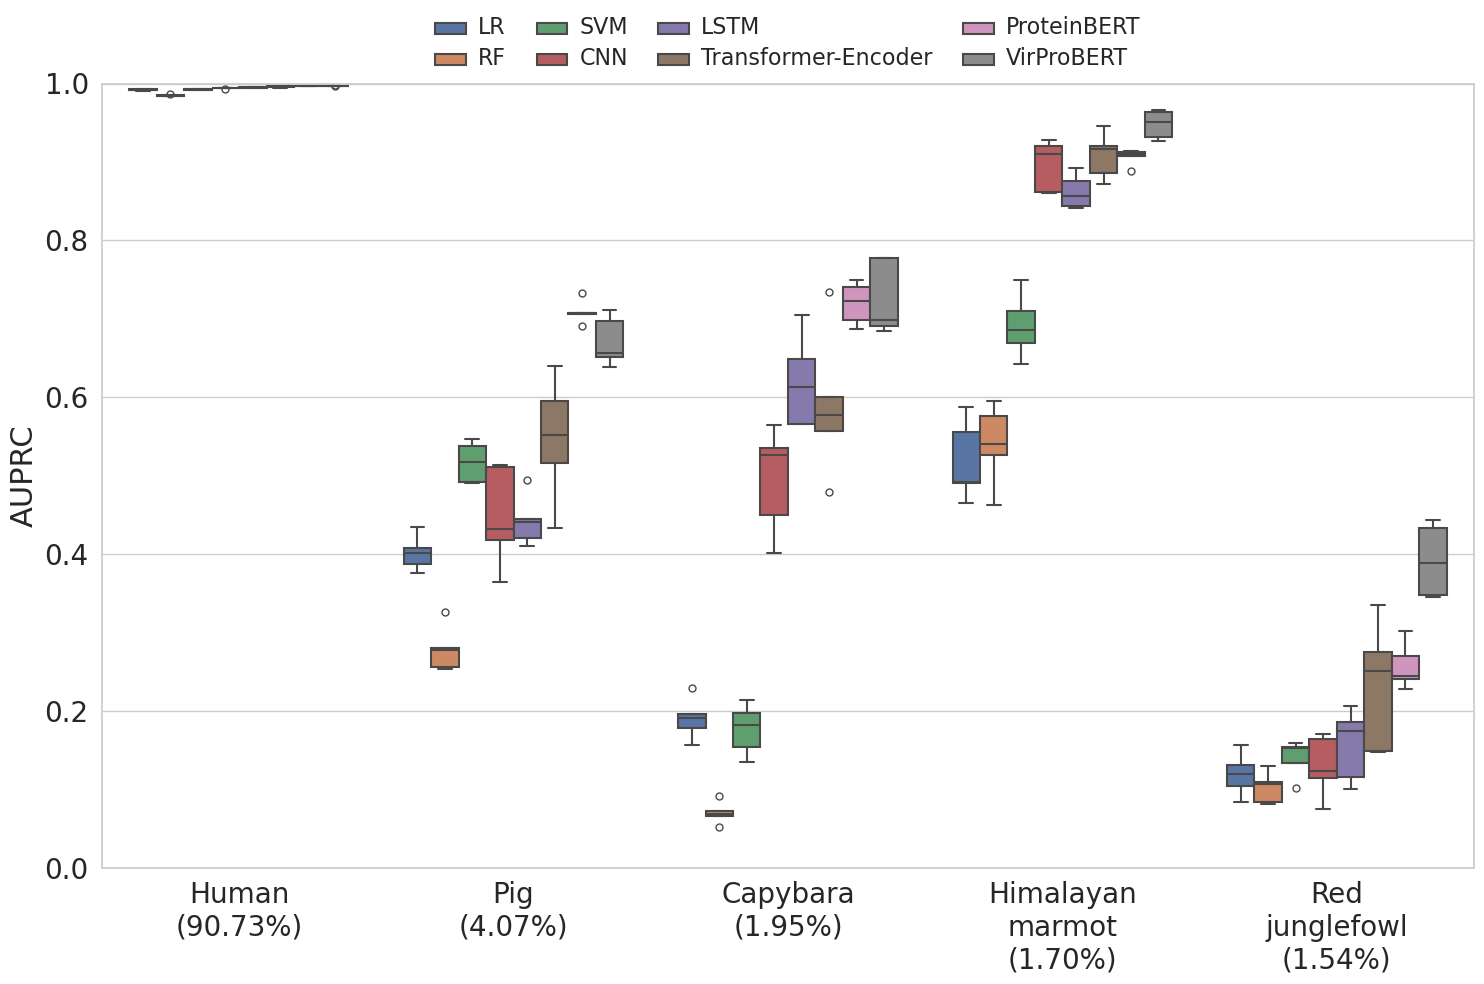

In [28]:
figure_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/visualization/uniref90/20240517/host_multi_all_models/host_multi_all_models_classwise_aurpc_boxplot.pdf")

auprc_results_df = class_wise_auprc_analysis(output_filepaths, classes, figure_output_filepath)

In [ ]:
virprobert_auprc_results_df = auprc_results_df[auprc_results_df["model"] == "VirProBERT"]

In [ ]:
virprobert_auprc_results_df

In [ ]:
virprobert_auprc_results_df[["class", "auprc"]].groupby("class").mean("auprc")